# Average data on group level

We average each z-scored time series, weighted with the design (rest is inverted before averaging). We then average over all patients of one group. This excludes patients deemed inconclusive by the 2D-LI method performed in the previous step.  
The results of this notebook will not be used in later analyses, as we later use leave-one-out. They only serve the purpose of visualizing the whole group. The companion notebook to this one is #7, where we show the same maps, but on a surface rather than in volume space.

### import modules

In [6]:
import glob
import pickle
import shutil

import pandas as pd
from scipy import stats

from nilearn import input_data, image, plotting

import matplotlib.pyplot as plt

### get data

In [3]:
data_df = pd.read_csv('../data/interim/csv/info_epi_zscored_zdiff_summarymaps_2dpredclean_df.csv',
                      index_col=[0,1],
                      header=0)

In [ ]:
data_df.tail()

### count wadas

In [10]:
data_df.groupby(level=1).count().mean(axis=1)

wada
bilateral    14.0
left         59.0
right        23.0
dtype: float64

### get the conclusive data

In [11]:
is_conclusive = data_df.loc[:, 'pred'] != 'inconclusive'
conc_df = data_df[is_conclusive]

In [12]:
conc_df.shape

(63, 14)

### accuracy of 2D-prediction

Just a quick sanity check if this still works. In [Wegrzyn et al. 2019](https://dx.doi.org/10.3389/fneur.2019.00655) it was 85% for a sample with 62% typical.

In [19]:
(conc_df.index.get_level_values(1) == conc_df['pred']).mean().round(2)

0.83

### extract data

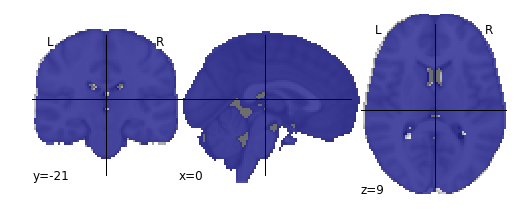

In [53]:
masker = input_data.NiftiMasker('../data/external/MNI152_T1_2mm_brain_mask.nii.gz').fit()
plotting.plot_roi(masker.mask_img_);

### collect data

In [54]:
def make_group_df(data_df, metric='z-scored', masker=masker):
    """get data of all conclusive patients, put into big table"""

    # only conclusive patients
    is_conclusive = data_df.loc[:, 'pred'] != 'inconclusive'
    conc_data_df = data_df[is_conclusive]

    ims = conc_data_df.loc[:, 'meanMap_%s'%metric]
    data = masker.transform(ims)
    df = pd.DataFrame(data)
    df.index = pd.MultiIndex.from_tuples(conc_data_df.index)

    return df

In [55]:
mean_df = make_group_df(data_df)

In [ ]:
mean_df.tail()

In [59]:
mean_df.groupby(level=1).count().mean(axis=1)

bilateral    10.0
left         39.0
right        14.0
dtype: float64

### group averages

Average all patients belonging to one wada group

In [60]:
group_mean_df = mean_df.groupby(level=1).mean()

In [61]:
group_mean_df

,0,1,2,3,4,5,6,7,8,9,...,228473,228474,228475,228476,228477,228478,228479,228480,228481,228482
bilateral,-0.028328,-0.052254,-0.075231,-0.073856,-0.101605,-0.031915,-0.095321,-0.135784,-0.106604,0.039152,...,0.010091,0.011257,0.047175,0.110739,0.117238,0.084405,0.048171,0.098301,0.094724,0.054371
left,-0.078082,-0.077480,-0.081773,-0.073813,-0.068284,-0.081093,-0.082297,-0.078213,-0.088812,-0.179790,...,-0.105986,-0.124016,-0.140716,-0.137692,-0.136460,-0.132448,-0.161991,-0.174777,-0.169027,-0.191340
right,-0.040057,-0.008815,-0.024527,-0.091000,-0.063911,-0.160825,-0.138340,-0.125144,-0.199467,-0.193345,...,-0.146684,-0.168316,-0.157606,-0.202938,-0.223406,-0.229653,-0.190354,-0.227394,-0.245371,-0.214429


Store the group averages to file

In [62]:
for i in group_mean_df.index:
    
    data = group_mean_df.loc[i,:]
    im = masker.inverse_transform(data)

    im.to_filename('../data/processed/nii/zOrig_%s.nii.gz'%i)

### t-maps

In [88]:
group_df = mean_df.reorder_levels([1,0])
group_df = group_df.sort_index()

for group in group_df.index.levels[0]:
    this_group_df = group_df.loc[group]
    t,p = stats.ttest_1samp(this_group_df,0)
    t_im = masker.inverse_transform(t)
    t_im.to_filename('../data/processed/nii/tOrig_%s.nii.gz'%group)

### same thing, for L-R diff images

In [89]:
mean_diff_df = make_group_df(data_df,'z-scored-diff')

In [90]:
group_mean_diff_df = mean_diff_df.groupby(level=1).mean()

In [91]:
group_mean_diff_df

,0,1,2,3,4,5,6,7,8,9,...,228473,228474,228475,228476,228477,228478,228479,228480,228481,228482
bilateral,-0.028328,-0.052254,-0.075231,-0.073856,-0.101605,-0.031915,-0.095321,-0.135784,-0.106604,0.039152,...,-0.047346,-0.045639,0.040147,0.134770,0.178138,0.181683,0.031486,0.120772,0.177139,0.097988
left,-0.078082,-0.077480,-0.081773,-0.073813,-0.068284,-0.081093,-0.082297,-0.078213,-0.088812,-0.179790,...,-0.002686,-0.030405,0.002503,-0.036043,-0.078600,-0.096911,-0.035973,-0.086986,-0.121797,-0.118582
right,-0.040057,-0.008815,-0.024527,-0.091000,-0.063911,-0.160825,-0.138340,-0.125144,-0.199467,-0.193345,...,0.253770,0.258670,-0.055720,-0.091948,-0.083754,-0.035825,-0.077407,-0.112683,-0.109293,-0.093027


In [92]:
for i in group_mean_diff_df.index:
    
    data = group_mean_diff_df.loc[i,:]
    im = masker.inverse_transform(data)

    im.to_filename('../data/processed/nii/zDiff_%s.nii.gz'%i)

### t-maps

In [93]:
group_diff_df = mean_diff_df.reorder_levels([1,0])
group_diff_df = group_diff_df.sort_index()

for group in group_diff_df.index.levels[0]:
    this_group_df = group_diff_df.loc[group]
    t,p = stats.ttest_1samp(this_group_df,0)
    t_im = masker.inverse_transform(t)
    t_im.to_filename('../data/processed/nii/tDiff_%s.nii.gz'%group)

### re-load and show the generated files

In [94]:
file_list = glob.glob('../data/processed/nii/z*.nii.gz')
file_list.sort()

In [95]:
file_list

['../data/processed/nii/zDiff_bilateral.nii.gz',
 '../data/processed/nii/zDiff_left.nii.gz',
 '../data/processed/nii/zDiff_right.nii.gz',
 '../data/processed/nii/zOrig_bilateral.nii.gz',
 '../data/processed/nii/zOrig_left.nii.gz',
 '../data/processed/nii/zOrig_right.nii.gz']

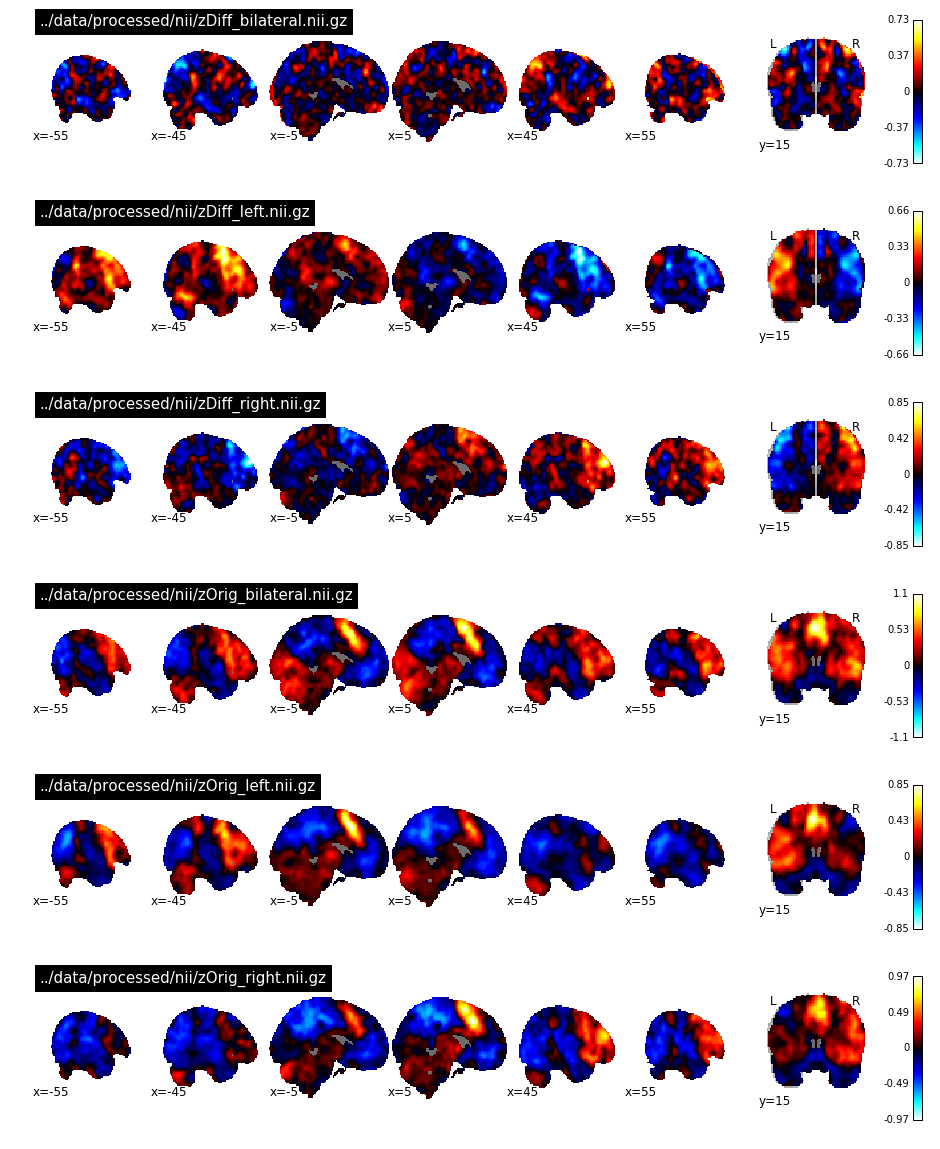

In [70]:
thresh = 0

n_ims = len(file_list)

fig = plt.figure(figsize=(16, 20))

for i, im in enumerate(file_list):

    ax = plt.subplot2grid((n_ims, 10), (i, 0), colspan=8)
    ax = plotting.plot_stat_map(
        im,
        display_mode='x',
        cut_coords=(-55, -45, -5, 5, 45, 55),
        threshold=thresh,
        title=im,
        colorbar=False,
        axes=ax)

    ax = plt.subplot2grid((n_ims, 10), (i, 8), colspan=2)
    ax = plotting.plot_stat_map(
        im,
        display_mode='y',
        cut_coords=([15]),
        threshold=thresh,
        colorbar=True,
        axes=ax)

plt.show()

### show t-maps

In [2]:
file_list = glob.glob('../data/processed/nii/t*.nii.gz')
file_list.sort()
file_list

['../data/processed/nii/tDiff_bilateral.nii.gz',
 '../data/processed/nii/tDiff_left.nii.gz',
 '../data/processed/nii/tDiff_right.nii.gz',
 '../data/processed/nii/tOrig_bilateral.nii.gz',
 '../data/processed/nii/tOrig_left.nii.gz',
 '../data/processed/nii/tOrig_right.nii.gz']

Copy to reports dir for later use

In [8]:
[shutil.copy2(f,'../reports/nii/') for f in file_list]

['../reports/nii/tDiff_bilateral.nii.gz',
 '../reports/nii/tDiff_left.nii.gz',
 '../reports/nii/tDiff_right.nii.gz',
 '../reports/nii/tOrig_bilateral.nii.gz',
 '../reports/nii/tOrig_left.nii.gz',
 '../reports/nii/tOrig_right.nii.gz']

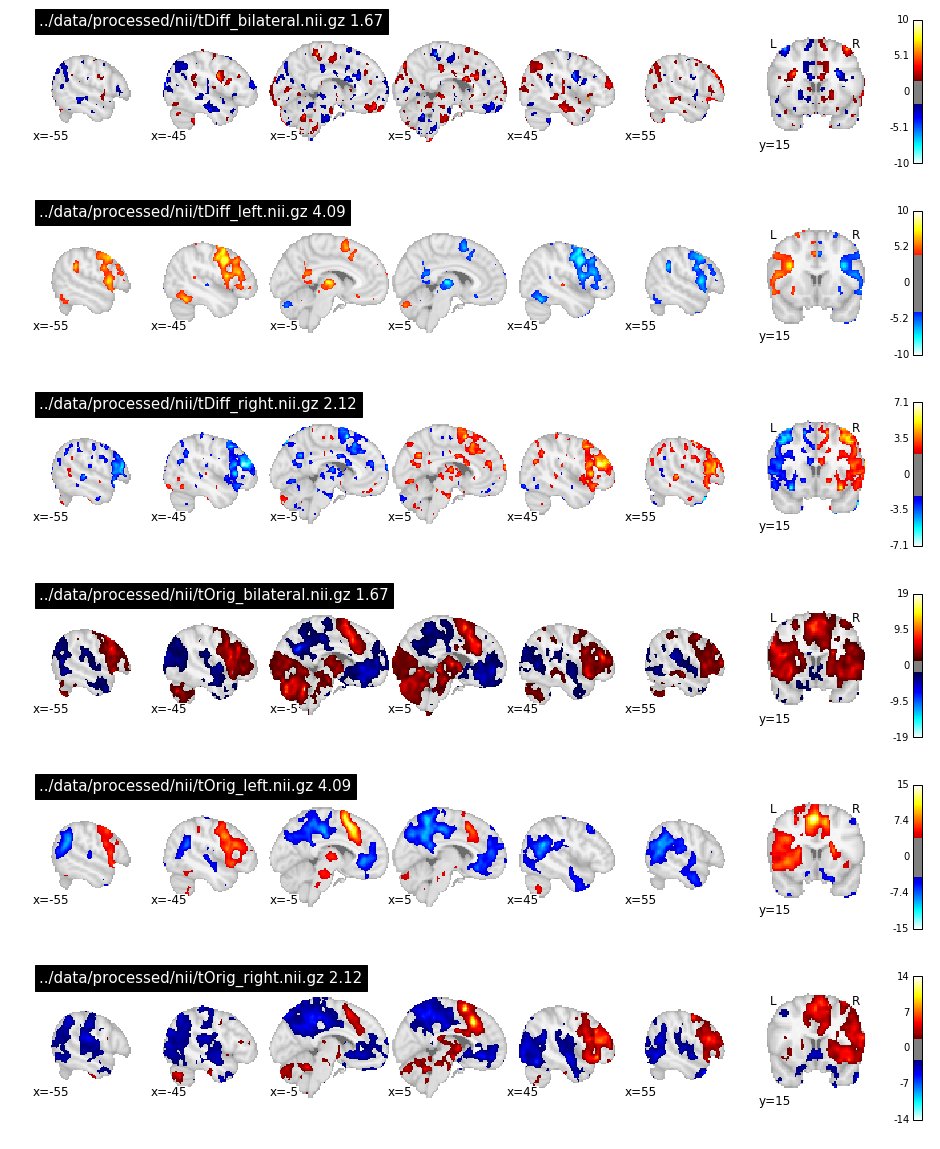

In [100]:
thresh_list = [1.67,4.09,2.12,1.67,4.09,2.12]

n_ims = len(file_list)

fig = plt.figure(figsize=(16, 20))

for i, (im,thresh) in enumerate(zip(file_list,thresh_list)):

    ax = plt.subplot2grid((n_ims, 10), (i, 0), colspan=8)
    ax = plotting.plot_stat_map(
        im,
        display_mode='x',
        cut_coords=(-55, -45, -5, 5, 45, 55),
        threshold=thresh,
        title='%s %.2f'%(im,thresh),
        colorbar=False,
        axes=ax)

    ax = plt.subplot2grid((n_ims, 10), (i, 8), colspan=2)
    ax = plotting.plot_stat_map(
        im,
        display_mode='y',
        cut_coords=([15]),
        threshold=thresh,
        colorbar=True,
        axes=ax)

plt.show()

### summary  

The figure illustrates the prototypical activity of each group, for the original data and for the L-R flipped data. In the flipped images, we see that differences between group are emphasized.


**************

< [Previous](05-mw-identify-inconclusive.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](07-mw-group-surface-plots.ipynb)